In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

In [2]:
sales_train = pd.read_excel('Sales.xlsx', sheet_name='Train')

In [3]:
sales_test = pd.read_excel('Sales.xlsx', sheet_name='Test')

In [6]:
sales_train['Total Books'] = sales_train.apply(lambda x: x['Units Sold'] + x['Available Books in the shelf'], axis=1)
sales_train.head()

,Units Sold,Available Books in the shelf,Price,State,Time,Week,NewYear,MLK,Presidents,GoodFriday,Memorial,Independence,Labor,Thanksgiving,Christmas,BookCode,Total Books
0,6187.0,10146.68,14.474543,Arizona,Week End 01-06-19,2019-01-06,1,0,0,0,0,0,0,0,0,22722,16333.68
1,9123.0,15144.18,14.174504,Arizona,Week End 01-07-18,2018-01-07,1,0,0,0,0,0,0,0,0,22722,24267.18
2,6236.0,8356.24,14.150096,Arizona,Week End 01-13-19,2019-01-13,0,0,0,0,0,0,0,0,0,22722,14592.24
3,8080.0,11312.00,14.078218,Arizona,Week End 01-14-18,2018-01-14,0,0,0,0,0,0,0,0,0,22722,19392.00
4,5695.0,7289.60,14.238279,Arizona,Week End 01-20-19,2019-01-20,0,0,0,0,0,0,0,0,0,22722,12984.60


In [8]:
sales_train['% Books Available'] = sales_train.apply(lambda x: x['Available Books in the shelf']*100/x['Total Books'], axis=1)
sales_train.head()

,Units Sold,Available Books in the shelf,Price,State,Time,Week,NewYear,MLK,Presidents,GoodFriday,Memorial,Independence,Labor,Thanksgiving,Christmas,BookCode,Total Books,% Books Available
0,6187.0,10146.68,14.474543,Arizona,Week End 01-06-19,2019-01-06,1,0,0,0,0,0,0,0,0,22722,16333.68,62.121212
1,9123.0,15144.18,14.174504,Arizona,Week End 01-07-18,2018-01-07,1,0,0,0,0,0,0,0,0,22722,24267.18,62.406015
2,6236.0,8356.24,14.150096,Arizona,Week End 01-13-19,2019-01-13,0,0,0,0,0,0,0,0,0,22722,14592.24,57.264957
3,8080.0,11312.00,14.078218,Arizona,Week End 01-14-18,2018-01-14,0,0,0,0,0,0,0,0,0,22722,19392.00,58.333333
4,5695.0,7289.60,14.238279,Arizona,Week End 01-20-19,2019-01-20,0,0,0,0,0,0,0,0,0,22722,12984.60,56.140351


In [13]:
sales_train[['Year','Month','Day']] = sales_train.Week.astype(str).str.split("-",expand=True)
sales_train.head()

,Units Sold,Available Books in the shelf,Price,State,Time,Week,NewYear,MLK,Presidents,GoodFriday,...,Independence,Labor,Thanksgiving,Christmas,BookCode,Total Books,% Books Available,Year,Month,Day
0,6187.0,10146.68,14.474543,Arizona,Week End 01-06-19,2019-01-06,1,0,0,0,...,0,0,0,0,22722,16333.68,62.121212,2019,01,06
1,9123.0,15144.18,14.174504,Arizona,Week End 01-07-18,2018-01-07,1,0,0,0,...,0,0,0,0,22722,24267.18,62.406015,2018,01,07
2,6236.0,8356.24,14.150096,Arizona,Week End 01-13-19,2019-01-13,0,0,0,0,...,0,0,0,0,22722,14592.24,57.264957,2019,01,13
3,8080.0,11312.00,14.078218,Arizona,Week End 01-14-18,2018-01-14,0,0,0,0,...,0,0,0,0,22722,19392.00,58.333333,2018,01,14
4,5695.0,7289.60,14.238279,Arizona,Week End 01-20-19,2019-01-20,0,0,0,0,...,0,0,0,0,22722,12984.60,56.140351,2019,01,20


In [47]:
sales_test[['Year','Month','Day']] = sales_test.Week.astype(str).str.split("-",expand=True)
sales_test.head()

,Available Books in the shelf,Price,State,Time,Week,NewYear,MLK,Presidents,GoodFriday,Memorial,Independence,Labor,Thanksgiving,Christmas,BookCode,Year,Month,Day
0,5123.0,14.106784,Arizona,Week End 11-03-19,2019-11-03,0,0,0,0,0,0,0,0,0,22722,2019,11,03
1,10064.0,13.935992,Arizona,Week End 11-10-19,2019-11-10,0,0,0,0,0,0,0,0,0,22722,2019,11,10
2,8299.0,13.792752,Arizona,Week End 11-17-19,2019-11-17,0,0,0,0,0,0,0,0,0,22722,2019,11,17
3,6970.0,13.946064,Arizona,Week End 11-24-19,2019-11-24,0,0,0,0,0,0,0,0,0,22722,2019,11,24
4,9207.0,14.167042,Arizona,Week End 12-01-19,2019-12-01,0,0,0,0,0,0,0,1,0,22722,2019,12,01


In [14]:
## checking null values

sales_train.isnull().sum()

Units Sold                      0
Available Books in the shelf    0
Price                           0
State                           0
Time                            0
Week                            0
NewYear                         0
MLK                             0
Presidents                      0
GoodFriday                      0
Memorial                        0
Independence                    0
Labor                           0
Thanksgiving                    0
Christmas                       0
BookCode                        0
Total Books                     0
% Books Available               0
Year                            0
Month                           0
Day                             0
dtype: int64

In [49]:
sales_test.isnull().sum()

Available Books in the shelf    0
Price                           0
State                           0
Time                            0
Week                            0
NewYear                         0
MLK                             0
Presidents                      0
GoodFriday                      0
Memorial                        0
Independence                    0
Labor                           0
Thanksgiving                    0
Christmas                       0
BookCode                        0
Year                            0
Month                           0
Day                             0
dtype: int64

In [15]:
sales_train['NewYear'].value_counts()

0    49980
1      840
Name: NewYear, dtype: int64

In [50]:
sales_test['NewYear'].value_counts()

0    3780
Name: NewYear, dtype: int64

In [16]:
sales_train['MLK'].value_counts()

0    49035
1     1785
Name: MLK, dtype: int64

In [51]:
sales_test['MLK'].value_counts()

0    3780
Name: MLK, dtype: int64

In [17]:
sales_train['Presidents'].value_counts()

0    49980
1      840
Name: Presidents, dtype: int64

In [52]:
sales_test['Presidents'].value_counts()

0    3780
Name: Presidents, dtype: int64

In [18]:
sales_train.columns

Index(['Units Sold', 'Available Books in the shelf', 'Price', 'State', 'Time',
       'Week', 'NewYear', 'MLK', 'Presidents', 'GoodFriday', 'Memorial',
       'Independence', 'Labor', 'Thanksgiving', 'Christmas', 'BookCode',
       'Total Books', '% Books Available', 'Year', 'Month', 'Day'],
      dtype='object')

<Figure size 1728x1296 with 0 Axes>

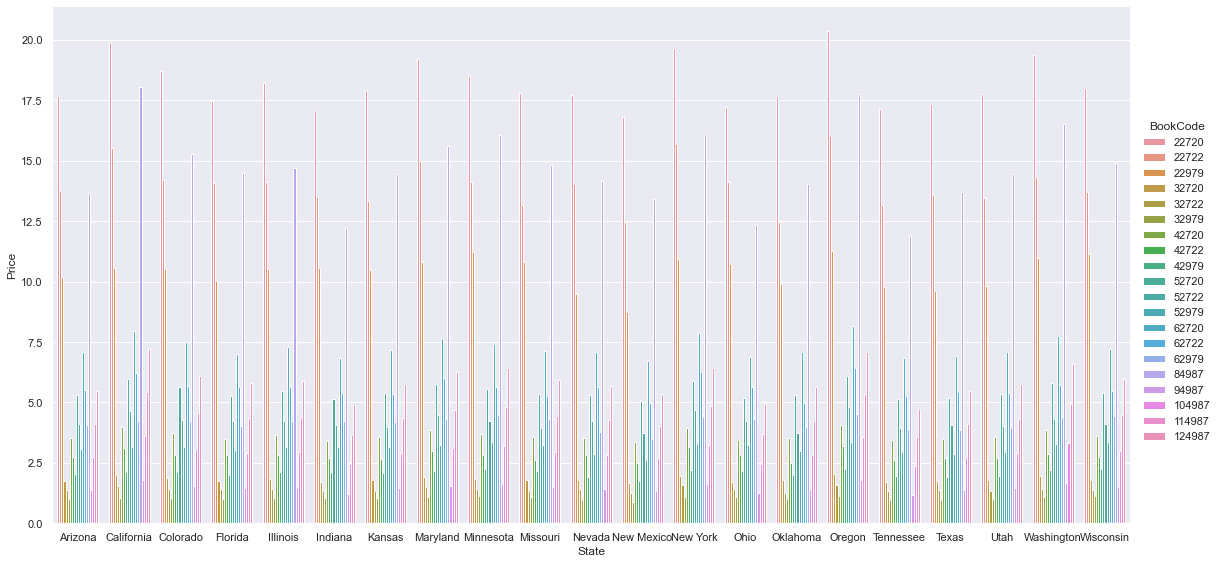

In [53]:
plt.figure(figsize=(24,18))
sns.catplot(x= 'State',y= 'Price', hue='BookCode', data=sales_train,kind='bar',ci=None,aspect=2, height = 8)


<Figure size 1728x1296 with 0 Axes>

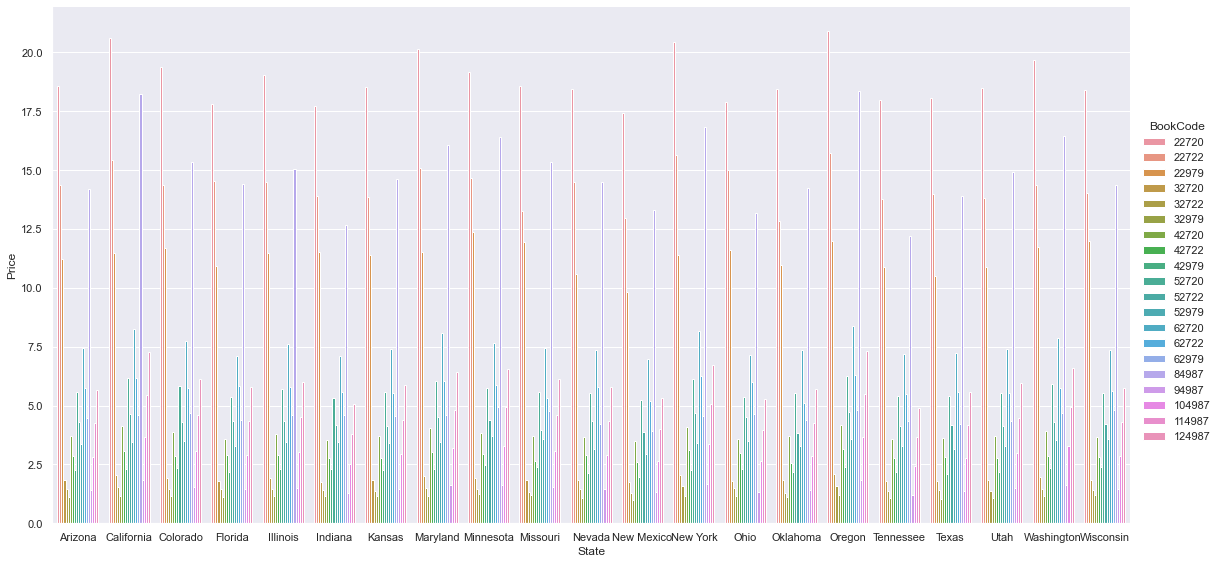

In [54]:
plt.figure(figsize=(24,18))
sns.catplot(x= 'State',y= 'Price', hue='BookCode', data=sales_test,kind='bar',ci=None, aspect=2, height = 8)


In [31]:
sales_2017 = sales_train[sales_train['Year']=='2017']
sales_2018 = sales_train[sales_train['Year']=='2018']
sales_2019 = sales_train[sales_train['Year']=='2019']


In [55]:
sales_test['Year'].unique()

array(['2019'], dtype=object)

<Figure size 1728x1296 with 0 Axes>

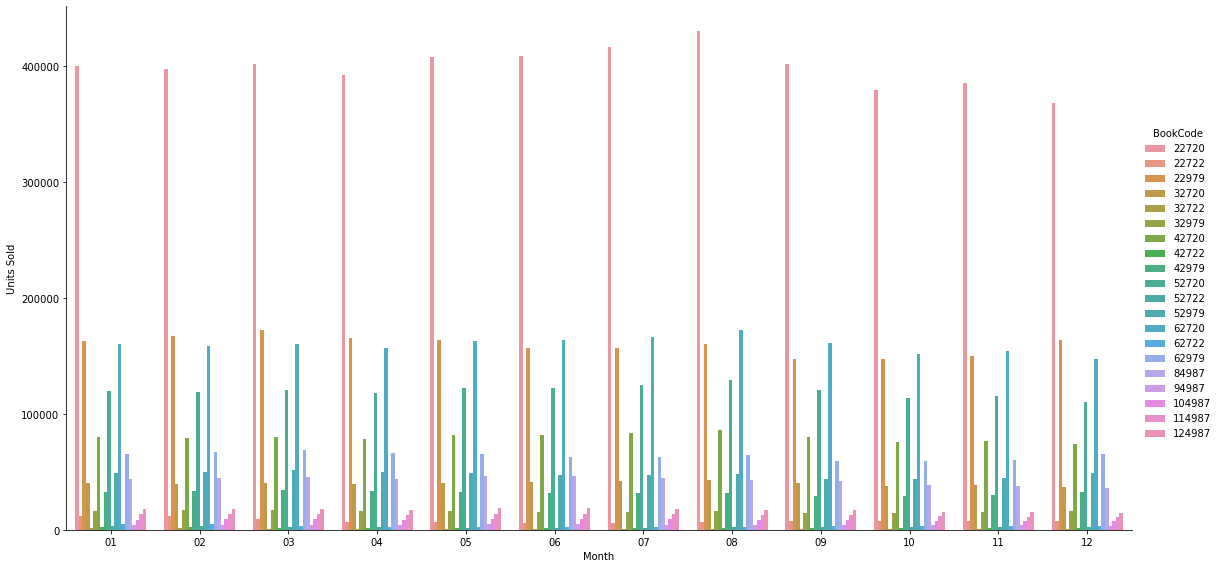

In [37]:
plt.figure(figsize=(24,18))
sns.catplot(x= 'Month',y= 'Units Sold', hue='BookCode', data=sales_2018,kind='bar',ci = None,aspect=2, height = 8)


<Figure size 1728x1296 with 0 Axes>

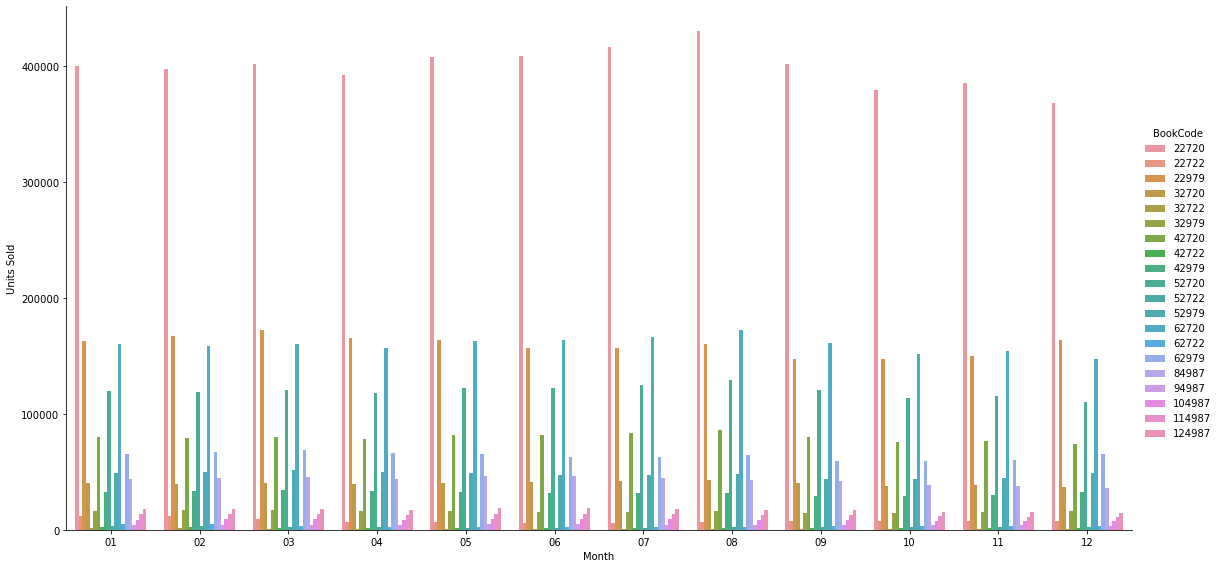

In [38]:
plt.figure(figsize=(24,18))
sns.catplot(x= 'Month',y= 'Units Sold', hue='BookCode', data=sales_2018,kind='bar',ci=None,aspect=2, height = 8)


<Figure size 1728x1296 with 0 Axes>

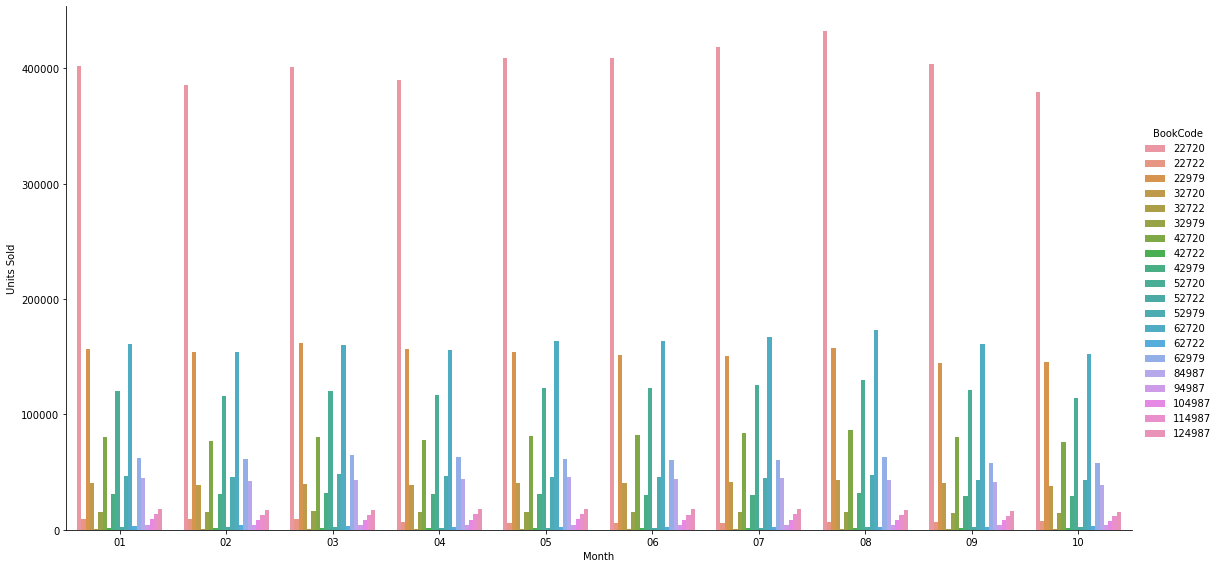

In [39]:
plt.figure(figsize=(24,18))
sns.catplot(x= 'Month',y= 'Units Sold', hue='BookCode', data=sales_2019,kind='bar',ci=None,aspect=2, height = 8)

<Figure size 1728x1296 with 0 Axes>

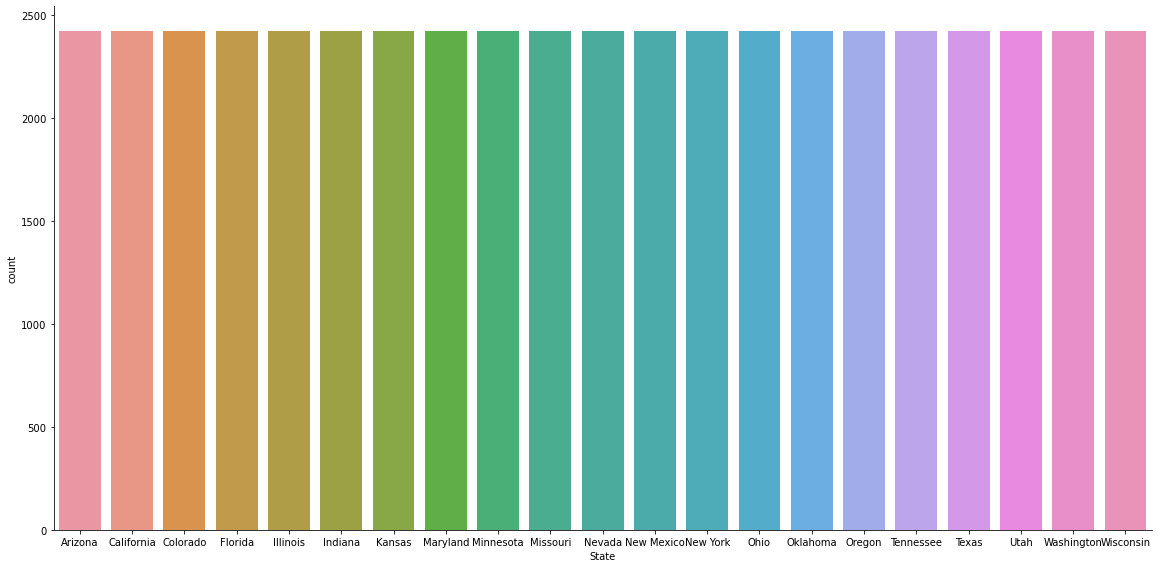

In [41]:
plt.figure(figsize=(24,18))
sns.catplot(x= 'State',
            data=sales_train,kind='count',aspect=2, height = 8)

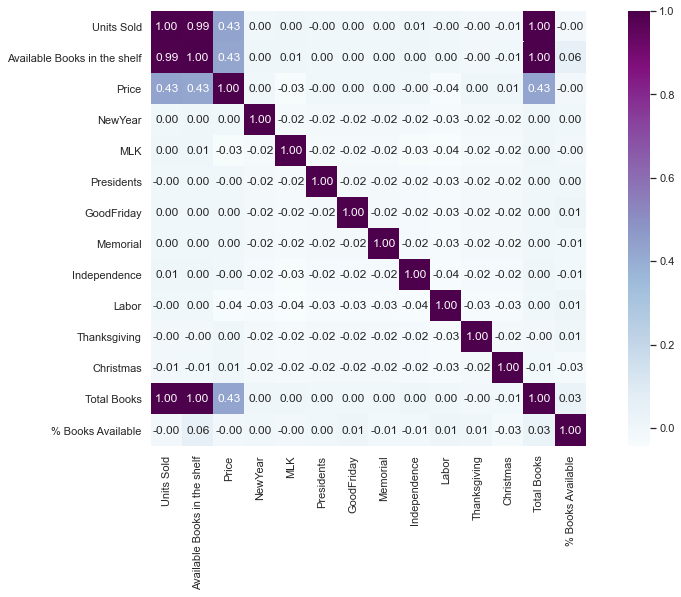

In [43]:
sales_corr = sales_train.drop(['BookCode'],axis=1)

matrix=sales_corr.corr()
f,ax=plt.subplots(figsize=(15,8))
sns.set(font_scale=1.0)
sns.heatmap(matrix,vmax=1, annot=True, square=True, fmt='.2f',cmap="BuPu")

In [58]:
sales_train['log(Units Sold)'] = np.log(sales_train['Units Sold'])
sales_train['log(Available Books)'] = np.log(sales_train['Available Books in the shelf'])
sales_test['log(Available Books)'] = np.log(sales_test['Available Books in the shelf'])


In [59]:
sales_train.head(2)

,Units Sold,Available Books in the shelf,Price,State,Time,Week,NewYear,MLK,Presidents,GoodFriday,...,Thanksgiving,Christmas,BookCode,Total Books,% Books Available,Year,Month,Day,log(Units Sold),log(Available Books)
0,6187.0,10146.68,14.474543,Arizona,Week End 01-06-19,2019-01-06,1,0,0,0,...,0,0,22722,16333.68,62.121212,2019,01,06,8.730206,9.224902
1,9123.0,15144.18,14.174504,Arizona,Week End 01-07-18,2018-01-07,1,0,0,0,...,0,0,22722,24267.18,62.406015,2018,01,07,9.118554,9.625372


In [60]:
sales_test.head(2)

,Available Books in the shelf,Price,State,Time,Week,NewYear,MLK,Presidents,GoodFriday,Memorial,Independence,Labor,Thanksgiving,Christmas,BookCode,Year,Month,Day,log(Available Books)
0,5123.0,14.106784,Arizona,Week End 11-03-19,2019-11-03,0,0,0,0,0,0,0,0,0,22722,2019,11,03,8.541495
1,10064.0,13.935992,Arizona,Week End 11-10-19,2019-11-10,0,0,0,0,0,0,0,0,0,22722,2019,11,10,9.216720


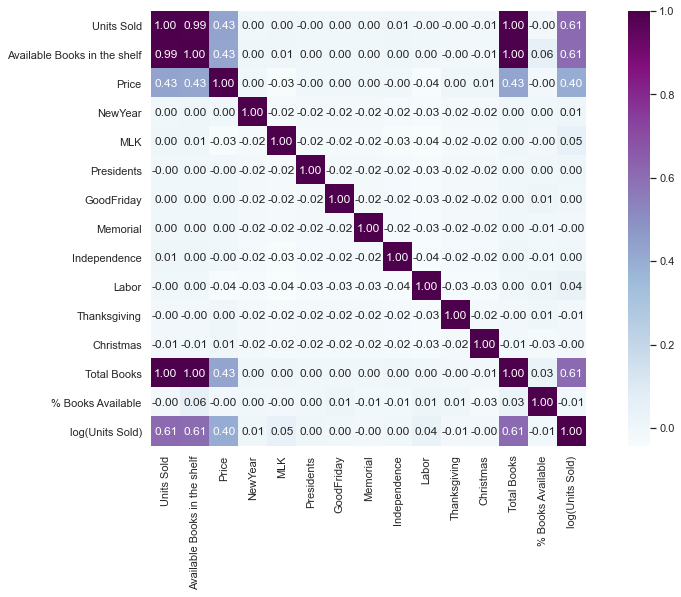

In [46]:
sales_corr = sales_train.drop(['BookCode'],axis=1)

matrix=sales_corr.corr()
f,ax=plt.subplots(figsize=(15,8))
sns.set(font_scale=1.0)
sns.heatmap(matrix,vmax=1, annot=True, square=True, fmt='.2f',cmap="BuPu")

Treating Categorical Variables

In [61]:
print('Train Shape',sales_train.shape)
print('Test Shape',sales_test.shape)

Train Shape (50820, 23)
Test Shape (3780, 19)


In [121]:
y= sales_train[['log(Units Sold)']]

In [77]:
sales_train = sales_train.drop(['Time'],axis=1)
sales_test = sales_test.drop(['Time'],axis=1)

In [93]:
train = sales_train.drop(['Year', 'Month', 'Day'],axis=1)
test = sales_test.drop(['Year', 'Month', 'Day'],axis=1)

In [94]:
sales_train_categorical = train.select_dtypes(include = 'object')
sales_test_categorical = test.select_dtypes(include = 'object')
print("Train Columns: ", sales_train_categorical.columns)
print("Test Columns: ", sales_test_categorical.columns)

Train Columns:  Index(['State'], dtype='object')
Test Columns:  Index(['State'], dtype='object')


In [95]:
train_obj_cols = sales_train_categorical.columns
test_obj_cols = sales_test_categorical.columns
train_df = train.drop(train_obj_cols,axis = 1)
test_df = test.drop(train_obj_cols,axis = 1)

In [96]:
print('Train Shape',train_df.shape)
print('Test Shape',test_df.shape)

Train Shape (50820, 18)
Test Shape (3780, 14)


In [109]:
train_df = train_df.drop(['Units Sold',
                         'Total Books','% Books Available','log(Units Sold)'],axis=1)

In [110]:
# also the unique number of categorical values aren't same, which results in different test and train shape
train_len = train_df.shape[0]

# Combining the two categorical datsets one after the other
combined = pd.concat([sales_train_categorical,sales_test_categorical],ignore_index=True, sort = False)
categorical_cols = combined.columns


# Creating Label Encoded values for the categorical values avoid the dummy variable trap
dummies = pd.get_dummies(combined, columns=categorical_cols,  drop_first = True)

# Seperating the datasets from combined dataset
train_dummies = dummies[:train_len]
test_dummies = dummies[train_len:]

In [111]:
print('Train Shape',train_df.shape)
print('Test Shape',test_df.shape)

Train Shape (50820, 14)
Test Shape (3780, 14)


In [112]:
print('Train Shape',train_dummies.shape)
print('Test Shape',test_dummies.shape)

Train Shape (50820, 20)
Test Shape (3780, 20)


In [113]:
train_dummies.head(2)

,State_California,State_Colorado,State_Florida,State_Illinois,State_Indiana,State_Kansas,State_Maryland,State_Minnesota,State_Missouri,State_Nevada,State_New Mexico,State_New York,State_Ohio,State_Oklahoma,State_Oregon,State_Tennessee,State_Texas,State_Utah,State_Washington,State_Wisconsin
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [114]:
# Concatenating with the main DataFrame
train_df.reset_index(drop=True, inplace=True)
train_dummies.reset_index(drop=True, inplace=True)
df_train = pd.concat([train_df,train_dummies],axis = 1)
print(df_train.shape)

(50820, 34)


In [115]:
test_df.reset_index(drop=True, inplace=True)
test_dummies.reset_index(drop=True, inplace=True)
df_test = pd.concat([test_df,test_dummies],axis = 1)

In [116]:
print('Train Shape',df_train.shape)
print('Test Shape',df_test.shape)

Train Shape (50820, 34)
Test Shape (3780, 34)


In [117]:
import datetime as dt
df_train['Week'] = pd.to_datetime(df_train['Week'])
df_train['Week']=df_train['Week'].map(dt.datetime.toordinal)

In [118]:
df_test['Week'] = pd.to_datetime(df_test['Week'])
df_test['Week']=df_test['Week'].map(dt.datetime.toordinal)

In [119]:

#Feature Scaling
from sklearn.preprocessing import StandardScaler

scaler_x = StandardScaler().fit(df_train)
train_X = scaler_x.transform(df_train)
test_X = scaler_x.transform(df_test)

In [122]:
y.head()

,log(Units Sold)
0,8.730206
1,9.118554
2,8.738094
3,8.997147
4,8.647344


In [124]:
y.shape

(50820, 1)

In [125]:
print('Train Shape',train_X.shape)
print('Test Shape',test_X.shape)

Train Shape (50820, 34)
Test Shape (3780, 34)


In [126]:
y.isnull().sum()

log(Units Sold)    0
dtype: int64